<a href="https://colab.research.google.com/github/AJ-Horch/customer_lifetime_value_prediction/blob/main/Customer_Lifetime_Value_Prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Lifetime Value Prediciton
Data: [Online Retail Data from UCI Repo](https://archive.ics.uci.edu/dataset/352/online+retail)

CLV is the total net revenue a company can expect from a single customer throughout their relationship
- The first objective is to calculate and predict future CLV, whic will help you find out how much each customer will spend
- The second objective is to identify profitable customers. The model will tell you who those valuable customers are
- The third goal is to take marketing actions based on the analysis from there, you will be able to optiize your marketing budget.


In [70]:
# Installing the PyMC Marketing library
!pip install pymc_marketing

In [71]:
!pip install openpyxl

In [72]:
!pip install arviz

In [73]:
!pip install lifetimes

In [74]:
# import required libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from arviz.labels import MapLabeller
from lifetimes import BetaGeoFitter

from IPython.display import Image
from pymc_marketing import clv

In [75]:
# setting the style of the plots
az.style.use('arviz-darkgrid')

%config InlineBackend.figure_format = 'retina' # good looking plots


In [76]:
import requests
import zipfile
import os

# Download the zip file
url = "https://archive.ics.uci.edu/static/public/352/online+retail.zip"
reponse = requests.get(url)
filename = 'online_retial.zip'

with open(filename, 'wb') as file:
  file.write(reponse.content)

# unzip the file
with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('online_retail_data')

# finding the excel file name
for file in os.listdir('online_retail_data'):
  if file.endswith(".xlsx"):
    excel_file = os.path.join("online_retail_data", file)
    break

# convert from excel to csv
data_raw = pd.read_excel(excel_file)

data_raw.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [77]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [78]:
# If the InvoiceNo starts with 'c' it indicates a cancellation
cancelled_orders = data_raw[data_raw['InvoiceNo'].astype(str).str.startswith("C")]

# Create a temporary DF with the columns I want to match on. Also negate the 'Quantity col
cancelled_orders['Quantity'] = -cancelled_orders['Quantity']

# Merge the orginal DF with the temp on the columns I want to match
merged_data = pd.merge(data_raw, cancelled_orders[['CustomerID', 'StockCode', 'Quantity',
                                                   'UnitPrice']],
                       on=['CustomerID', 'StockCode', 'Quantity', 'UnitPrice'],
                       how='left', indicator=True)

# Filter out rows where the merge found a match, and also filter out the orginal return orders
data_raw = merged_data[(merged_data['_merge'] == 'left_only') & (~merged_data['InvoiceNo'].astype(str).str.startswith("C"))]

# Drop the indicator column
data_raw = data_raw.drop(columns=['_merge'])

In [79]:
data_raw.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [80]:
# Selecting relevant features and calculating total sales
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Country']
data = data_raw[features]
data['TotalSales'] = data['Quantity'].multiply(data['UnitPrice'])

# Removing transactions with missing customer IDs - they dont contribute to individual customer behaviour
data = data[data['CustomerID'].notna()]
data['CustomerID'] = data['CustomerID'].astype(int).astype(str)
print(data.shape)
data.head()

(392695, 7)


CustomerID InvoiceNo         InvoiceDate  Quantity  UnitPrice  \
0      17850    536365 2010-12-01 08:26:00         6       2.55   
1      17850    536365 2010-12-01 08:26:00         6       3.39   
2      17850    536365 2010-12-01 08:26:00         8       2.75   
3      17850    536365 2010-12-01 08:26:00         6       3.39   
4      17850    536365 2010-12-01 08:26:00         6       3.39   

          Country  TotalSales  
0  United Kingdom       15.30  
1  United Kingdom       20.34  
2  United Kingdom       22.00  
3  United Kingdom       20.34  
4  United Kingdom       20.34

In [81]:
# Check for any missing values
pd.DataFrame(zip(data.isnull().sum(), data.isnull().sum()/len(data)), columns=['Count', 'Proportion'], index=data.columns)

Count  Proportion
CustomerID       0         0.0
InvoiceNo        0         0.0
InvoiceDate      0         0.0
Quantity         0         0.0
UnitPrice        0         0.0
Country          0         0.0
TotalSales       0         0.0

In [82]:
# Summarize the dataset's content to understand its scope
maxdate = data['InvoiceDate'].dt.date.max()
mindate = data['InvoiceDate'].dt.date.min()
unique_cust = data['CustomerID'].nunique()
tot_quantity = data['Quantity'].sum()
tot_sales = data['TotalSales'].sum()

print(f"The time range of transactions is: {mindate} to {maxdate}")
print(f"Total number of unique customers: {unique_cust}")
print(f"Total quantity sold: {tot_quantity}")
print(f"Total sales for the period: {tot_sales}")

The time range of transactions is: 2010-12-01 to 2011-12-09
Total number of unique customers: 4326
Total quantity sold: 4913316
Total sales for the period: 8391630.964


In [83]:
# Prep a summary from transaction data, transforming individua transaction data into data at the customer level

data_summary_rfm = clv.utils.clv_summary(data, 'CustomerID', 'InvoiceDate', 'TotalSales')
data_summary_rfm = data_summary_rfm.rename(columns={'CustomerID': 'customer_id'})
data_summary_rfm.index = data_summary_rfm['customer_id']
data_summary_rfm

/usr/local/lib/python3.11/dist-packages/pymc_marketing/clv/utils.py:268: UserWarning: clv_summary was renamed to rfm_summary
  warnings.warn("clv_summary was renamed to rfm_summary", UserWarning, stacklevel=1)


customer_id  frequency  recency      T  monetary_value
customer_id                                                       
12347             12347        6.0    365.0  367.0      599.701667
12348             12348        3.0    283.0  358.0      301.480000
12349             12349        0.0      0.0   18.0        0.000000
12350             12350        0.0      0.0  310.0        0.000000
12352             12352        5.0    260.0  296.0      221.756000
...                 ...        ...      ...    ...             ...
18280             18280        0.0      0.0  277.0        0.000000
18281             18281        0.0      0.0  180.0        0.000000
18282             18282        1.0    119.0  126.0       77.840000
18283             18283       13.0    334.0  337.0      152.802308
18287             18287        2.0    159.0  201.0      536.000000

[4326 rows x 5 columns]

In [84]:
data_summary_rfm = data_summary_rfm[data_summary_rfm['monetary_value'] > 0]

Percentage of customers who purchased only once: 31.68%


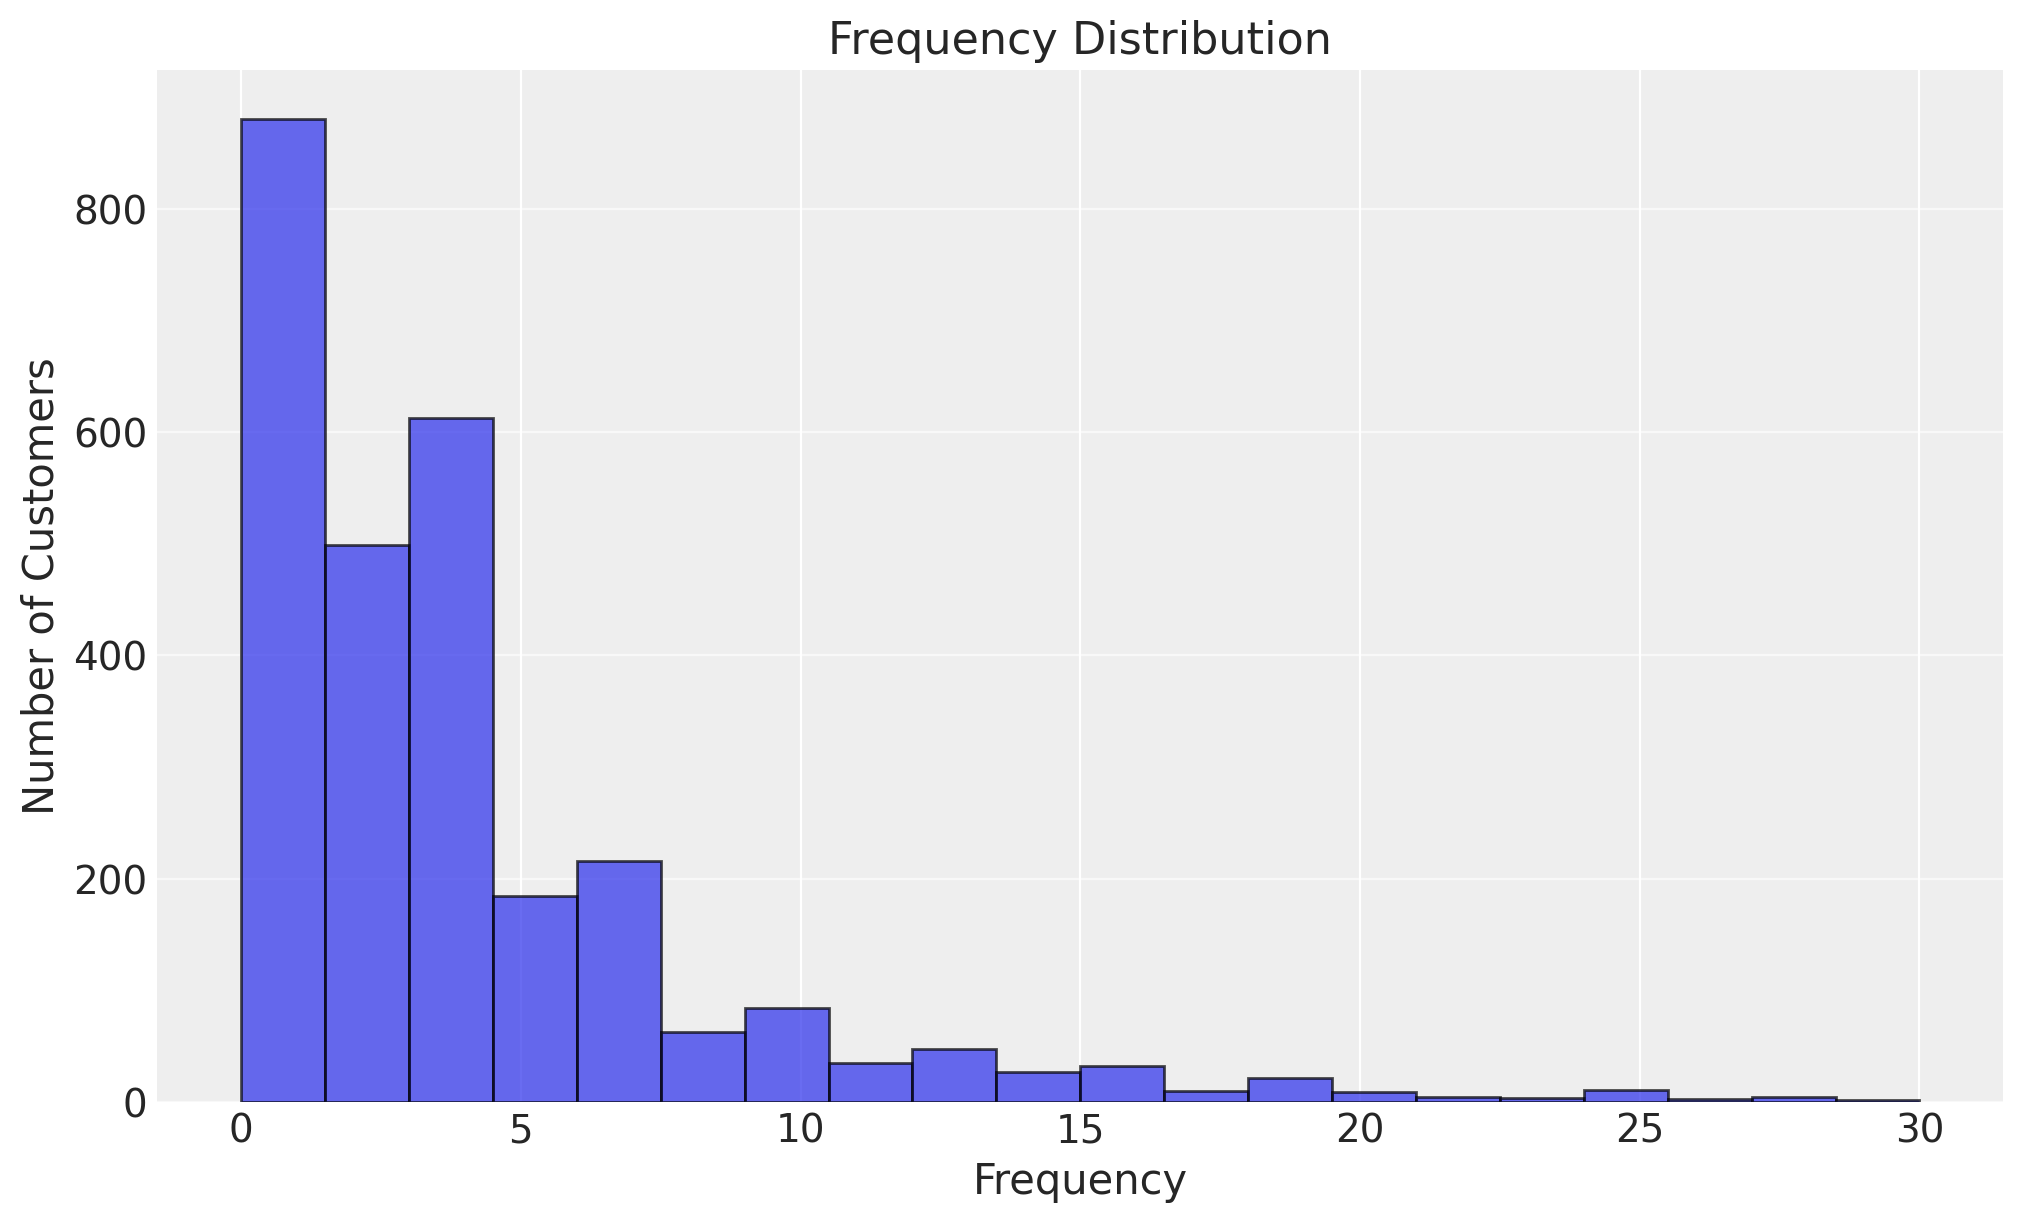

In [85]:
# Plotting the frequency dist of customers
plt.figure(figsize=(10, 6))
plt.hist(data_summary_rfm['frequency'], bins=20, range=[0, 30], edgecolor='k', alpha=0.7)
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Number of Customers')
plt.grid(axis='y', alpha=0.6)
plt.show

one_time = round(sum(data_summary_rfm['frequency'] == 1) / float(len(data_summary_rfm)) * 100, 2)
print(f"Percentage of customers who purchased only once: {one_time}%")

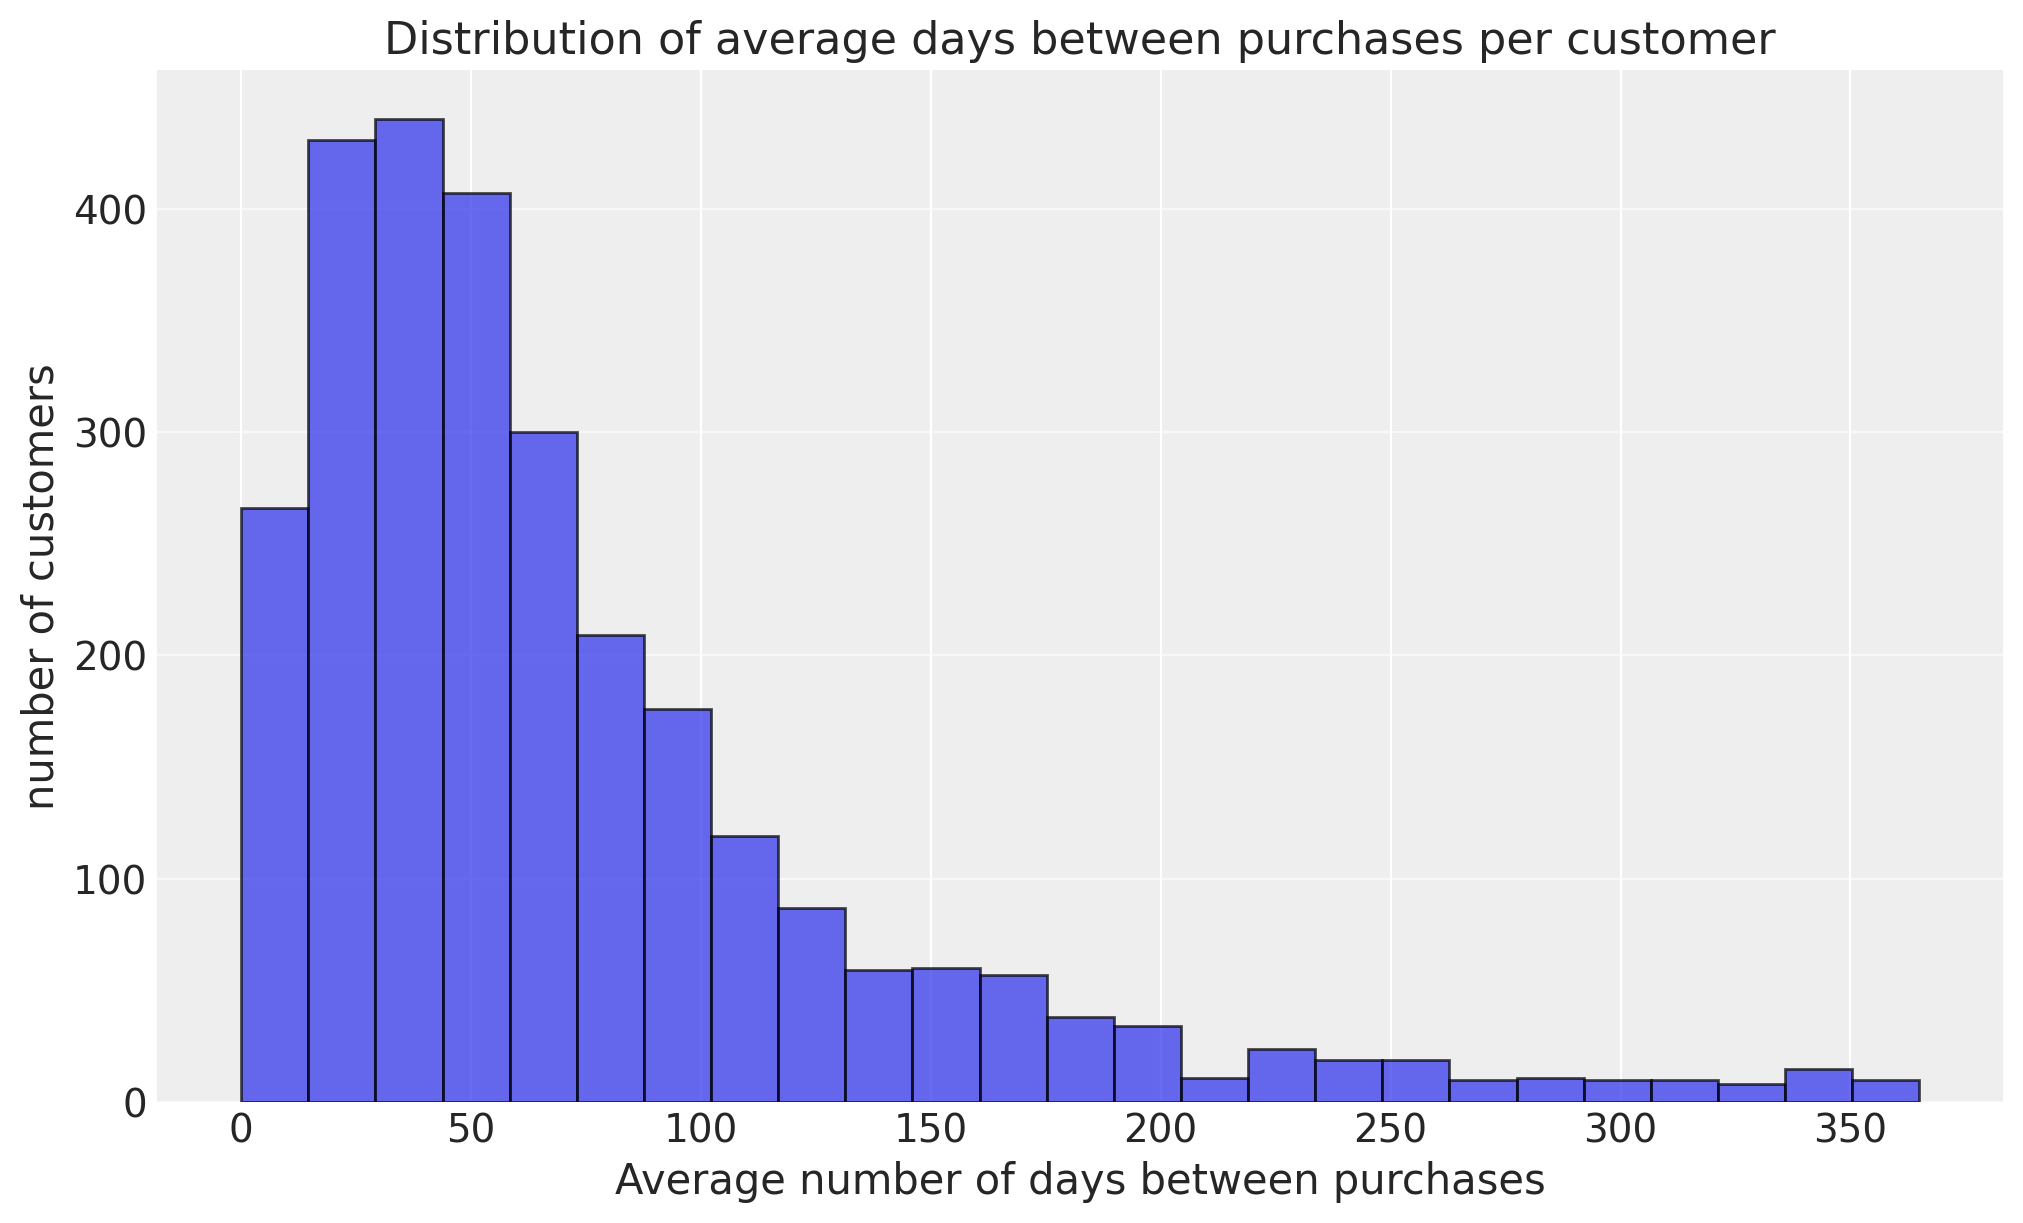

In [86]:
# Calculating Days between Purchases

# Select distinct CustomerID and InvoiceData
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
unique_purchases = data[['CustomerID', 'InvoiceDate']].drop_duplicates()

# Sorting values to esure the calculation of the difference correctly
unique_purchases['NextInvoiceDate'] = unique_purchases.groupby('CustomerID')['InvoiceDate'].shift(-1)
unique_purchases['DaysBetween'] = (unique_purchases['NextInvoiceDate'] - unique_purchases['InvoiceDate']).dt.days

# Calculate average days
customer_avg_days = unique_purchases.groupby('CustomerID')['DaysBetween'].mean().dropna()

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(customer_avg_days, bins=25, edgecolor='k', alpha=0.7)
plt.title('Distribution of average days between purchases per customer')
plt.xlabel('Average number of days between purchases')
plt.ylabel('number of customers')
plt.grid(axis='y', alpha=0.6)
plt.show()

In [87]:
data_summary_rfm

customer_id  frequency  recency      T  monetary_value
customer_id                                                       
12347             12347        6.0    365.0  367.0      599.701667
12348             12348        3.0    283.0  358.0      301.480000
12352             12352        5.0    260.0  296.0      221.756000
12356             12356        2.0    303.0  325.0      269.905000
12358             12358        1.0    149.0  150.0      683.200000
...                 ...        ...      ...    ...             ...
18272             18272        5.0    244.0  246.0      487.752000
18273             18273        2.0    255.0  257.0       76.500000
18282             18282        1.0    119.0  126.0       77.840000
18283             18283       13.0    334.0  337.0      152.802308
18287             18287        2.0    159.0  201.0      536.000000

[2778 rows x 5 columns]

In [88]:
# Initializing the BG/NBD model
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
)
bgm.build_model()
bgm

BG/NBD
            alpha ~ Weibull(2, 10)
      phi_dropout ~ Uniform(0, 1)
    kappa_dropout ~ Pareto(1, 1)
                r ~ Weibull(2, 1)
                a ~ Deterministic(f(kappa_dropout, phi_dropout))
                b ~ Deterministic(f(kappa_dropout, phi_dropout))
recency_frequency ~ BetaGeoNBD(a, b, r, alpha, <constant>)

### Configuring the model
While the default priors work well for large datasets, they can be too broad for smaller datasets. Therefore, we're refining our model by specifying more informative priors for the model's paramters. This step helps guiding the model towards more realistic areas of the parameter space

In [89]:
model_config = {
    'a_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},
    'b_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},
    'alpha_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},
    'r_prior': {'dist': 'HalfNormal',
                'kwargs': {'sigma':100}},

}

In [90]:
# rebuild the model with the new config
bgm = clv.BetaGeoModel(
    data = data_summary_rfm,
    model_config = model_config,
)
bgm.build_model()
bgm

BG/NBD
            alpha ~ HalfNormal(0, 100)
                a ~ HalfNormal(0, 100)
                b ~ HalfNormal(0, 100)
                r ~ HalfNormal(0, 100)
recency_frequency ~ BetaGeoNBD(a, b, r, alpha, <constant>)

In [91]:
bgm.fit()

Output()

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [92]:
bgm.fit_summary()

mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a        0.012  0.005    0.003    0.022      0.000    0.000     851.0   
alpha  110.115  4.447  101.831  118.488      0.173    0.136     657.0   
b        0.233  0.112    0.053    0.437      0.004    0.004     874.0   
r        1.947  0.072    1.807    2.074      0.003    0.002     639.0   

       ess_tail  r_hat  
a         684.0    1.0  
alpha     796.0    1.0  
b         683.0    1.0  
r         584.0    1.0

Visualising the posterior distributions of the parameters. These distribution show the range of probable values for each parameter, considering the observed data.

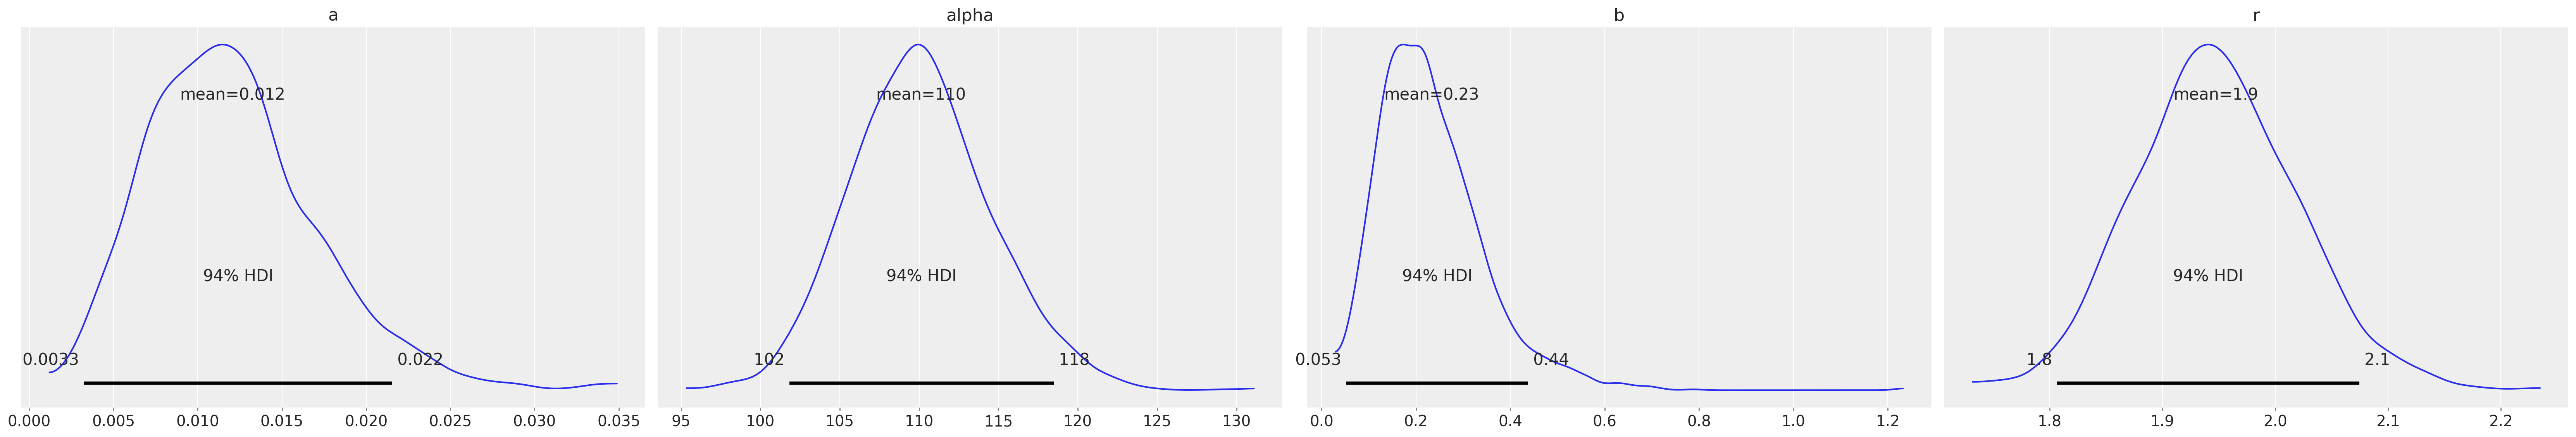

In [93]:
az.plot_posterior(bgm.fit_result);

Next I'm analysing customer behavior using a Frequency/Recency matrix, which visualises customer archtypes. This matric helps in identifying patterns like potentially 'at-risk' cutomers who might churn.

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

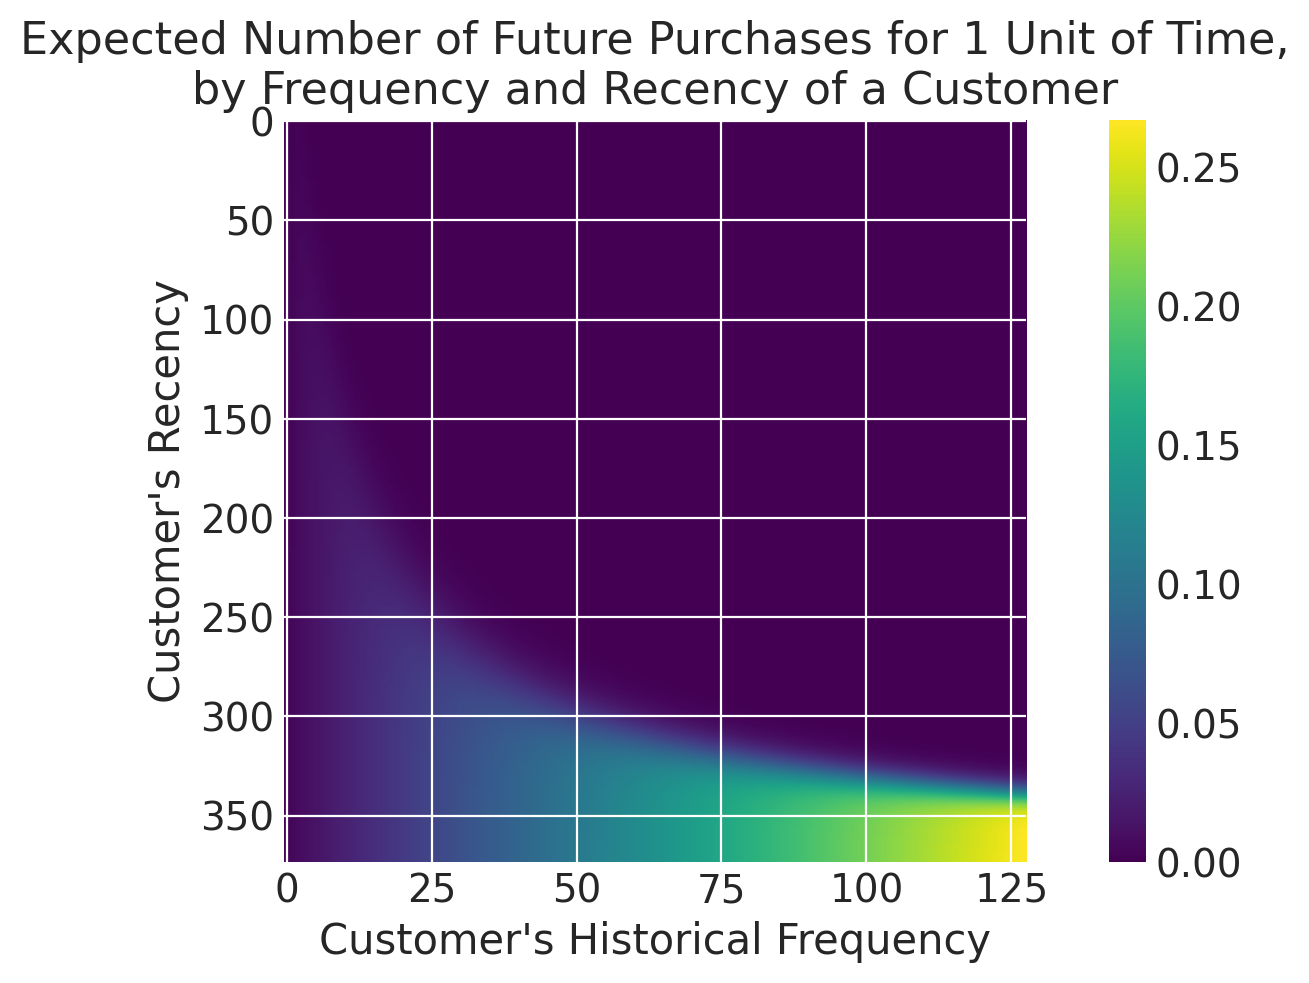

In [94]:
clv.plot_frequency_recency_matrix(bgm)

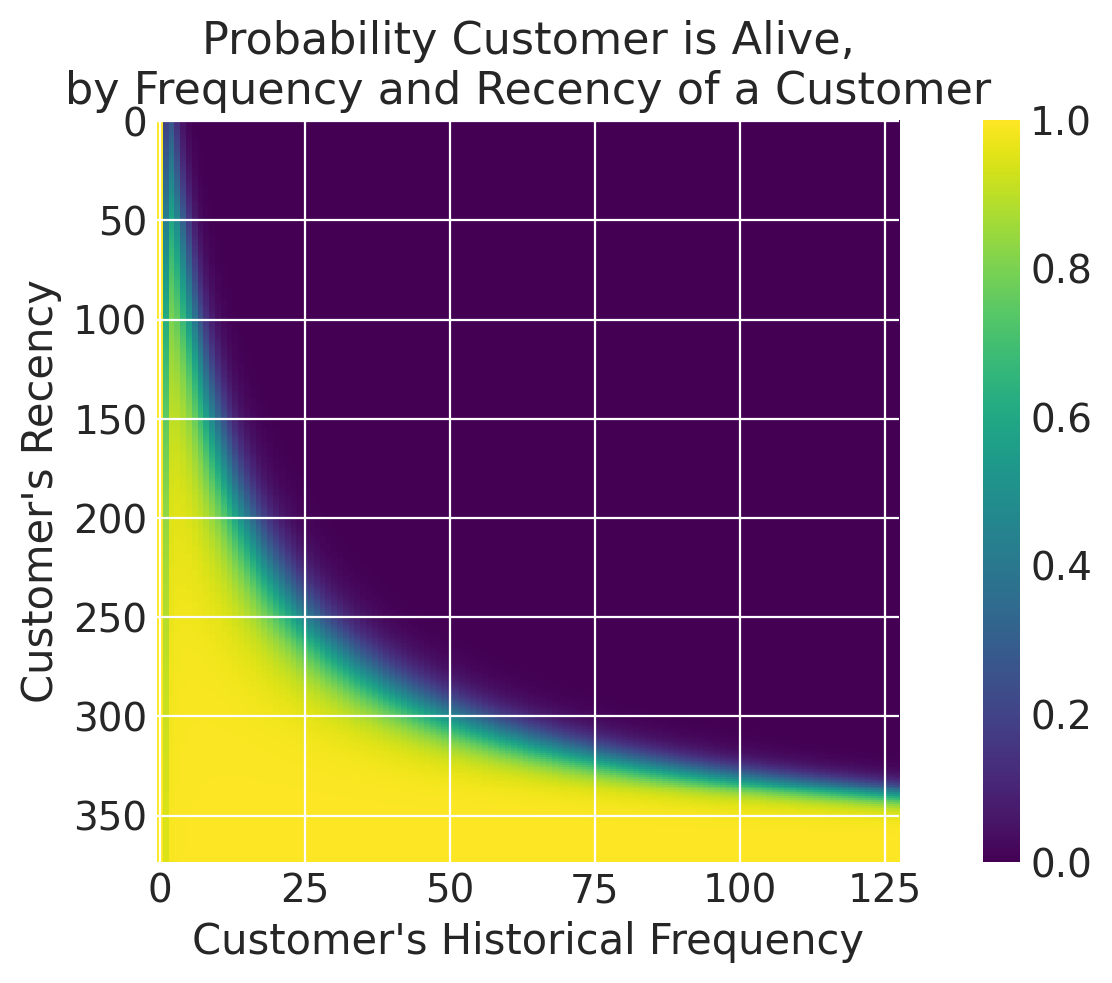

In [95]:
# The Probability Alive Matrix visualises the likelihood of customers still being active
# This view is essential for identifying potentially lost customers and understanding overall customer retention

clv.plot_probability_alive_matrix(bgm);

## How to interpret this graph
Top right corner: Low Frequency, Low Recency - Passerbay
Top left corner: High Frequency, Low Recency - Loyal but at risk of leaving
Bottom right corner: Low Frequency, High Recency - New Customers
Bottom Left corner: High Frequency, High Recency - Loyal customers buying

If I was in charge of marketing I would priortise strategies in the following way:
1. Offer loyal but at risk customers a promotion to get them to buy again
2. Incentise new customers to make another purchase
3. Offer incentises to loyal customers for being loyal -  a reward

In [96]:
# predicting future purchases whithin the next 365 days using the fitted model
num_purchases = bgm.expected_num_purchases(
    customer_id=data_summary_rfm['customer_id'],
    t=365,
    frequency=data_summary_rfm['frequency'],
    recency=data_summary_rfm['recency'],
    T=data_summary_rfm['T']
)

In [97]:
# We add expected purchases to our sata summary and display the customers with the hightest expected purchases

sdata = data_summary_rfm.copy()
sdata['expected_purchases'] = num_purchases.mean(("chain", "draw")).values
sdata.sort_values(by="expected_purchases").tail(4)

customer_id  frequency  recency      T  monetary_value  \
customer_id                                                          
15311             15311       89.0    373.0  373.0      660.002809   
17841             17841      111.0    372.0  373.0      341.128018   
12748             12748      112.0    373.0  373.0      284.600893   
14911             14911      127.0    372.0  373.0      953.531890   

             expected_purchases  
customer_id                      
15311                 68.447285  
17841                 85.006059  
12748                 85.761293  
14911                 97.050182

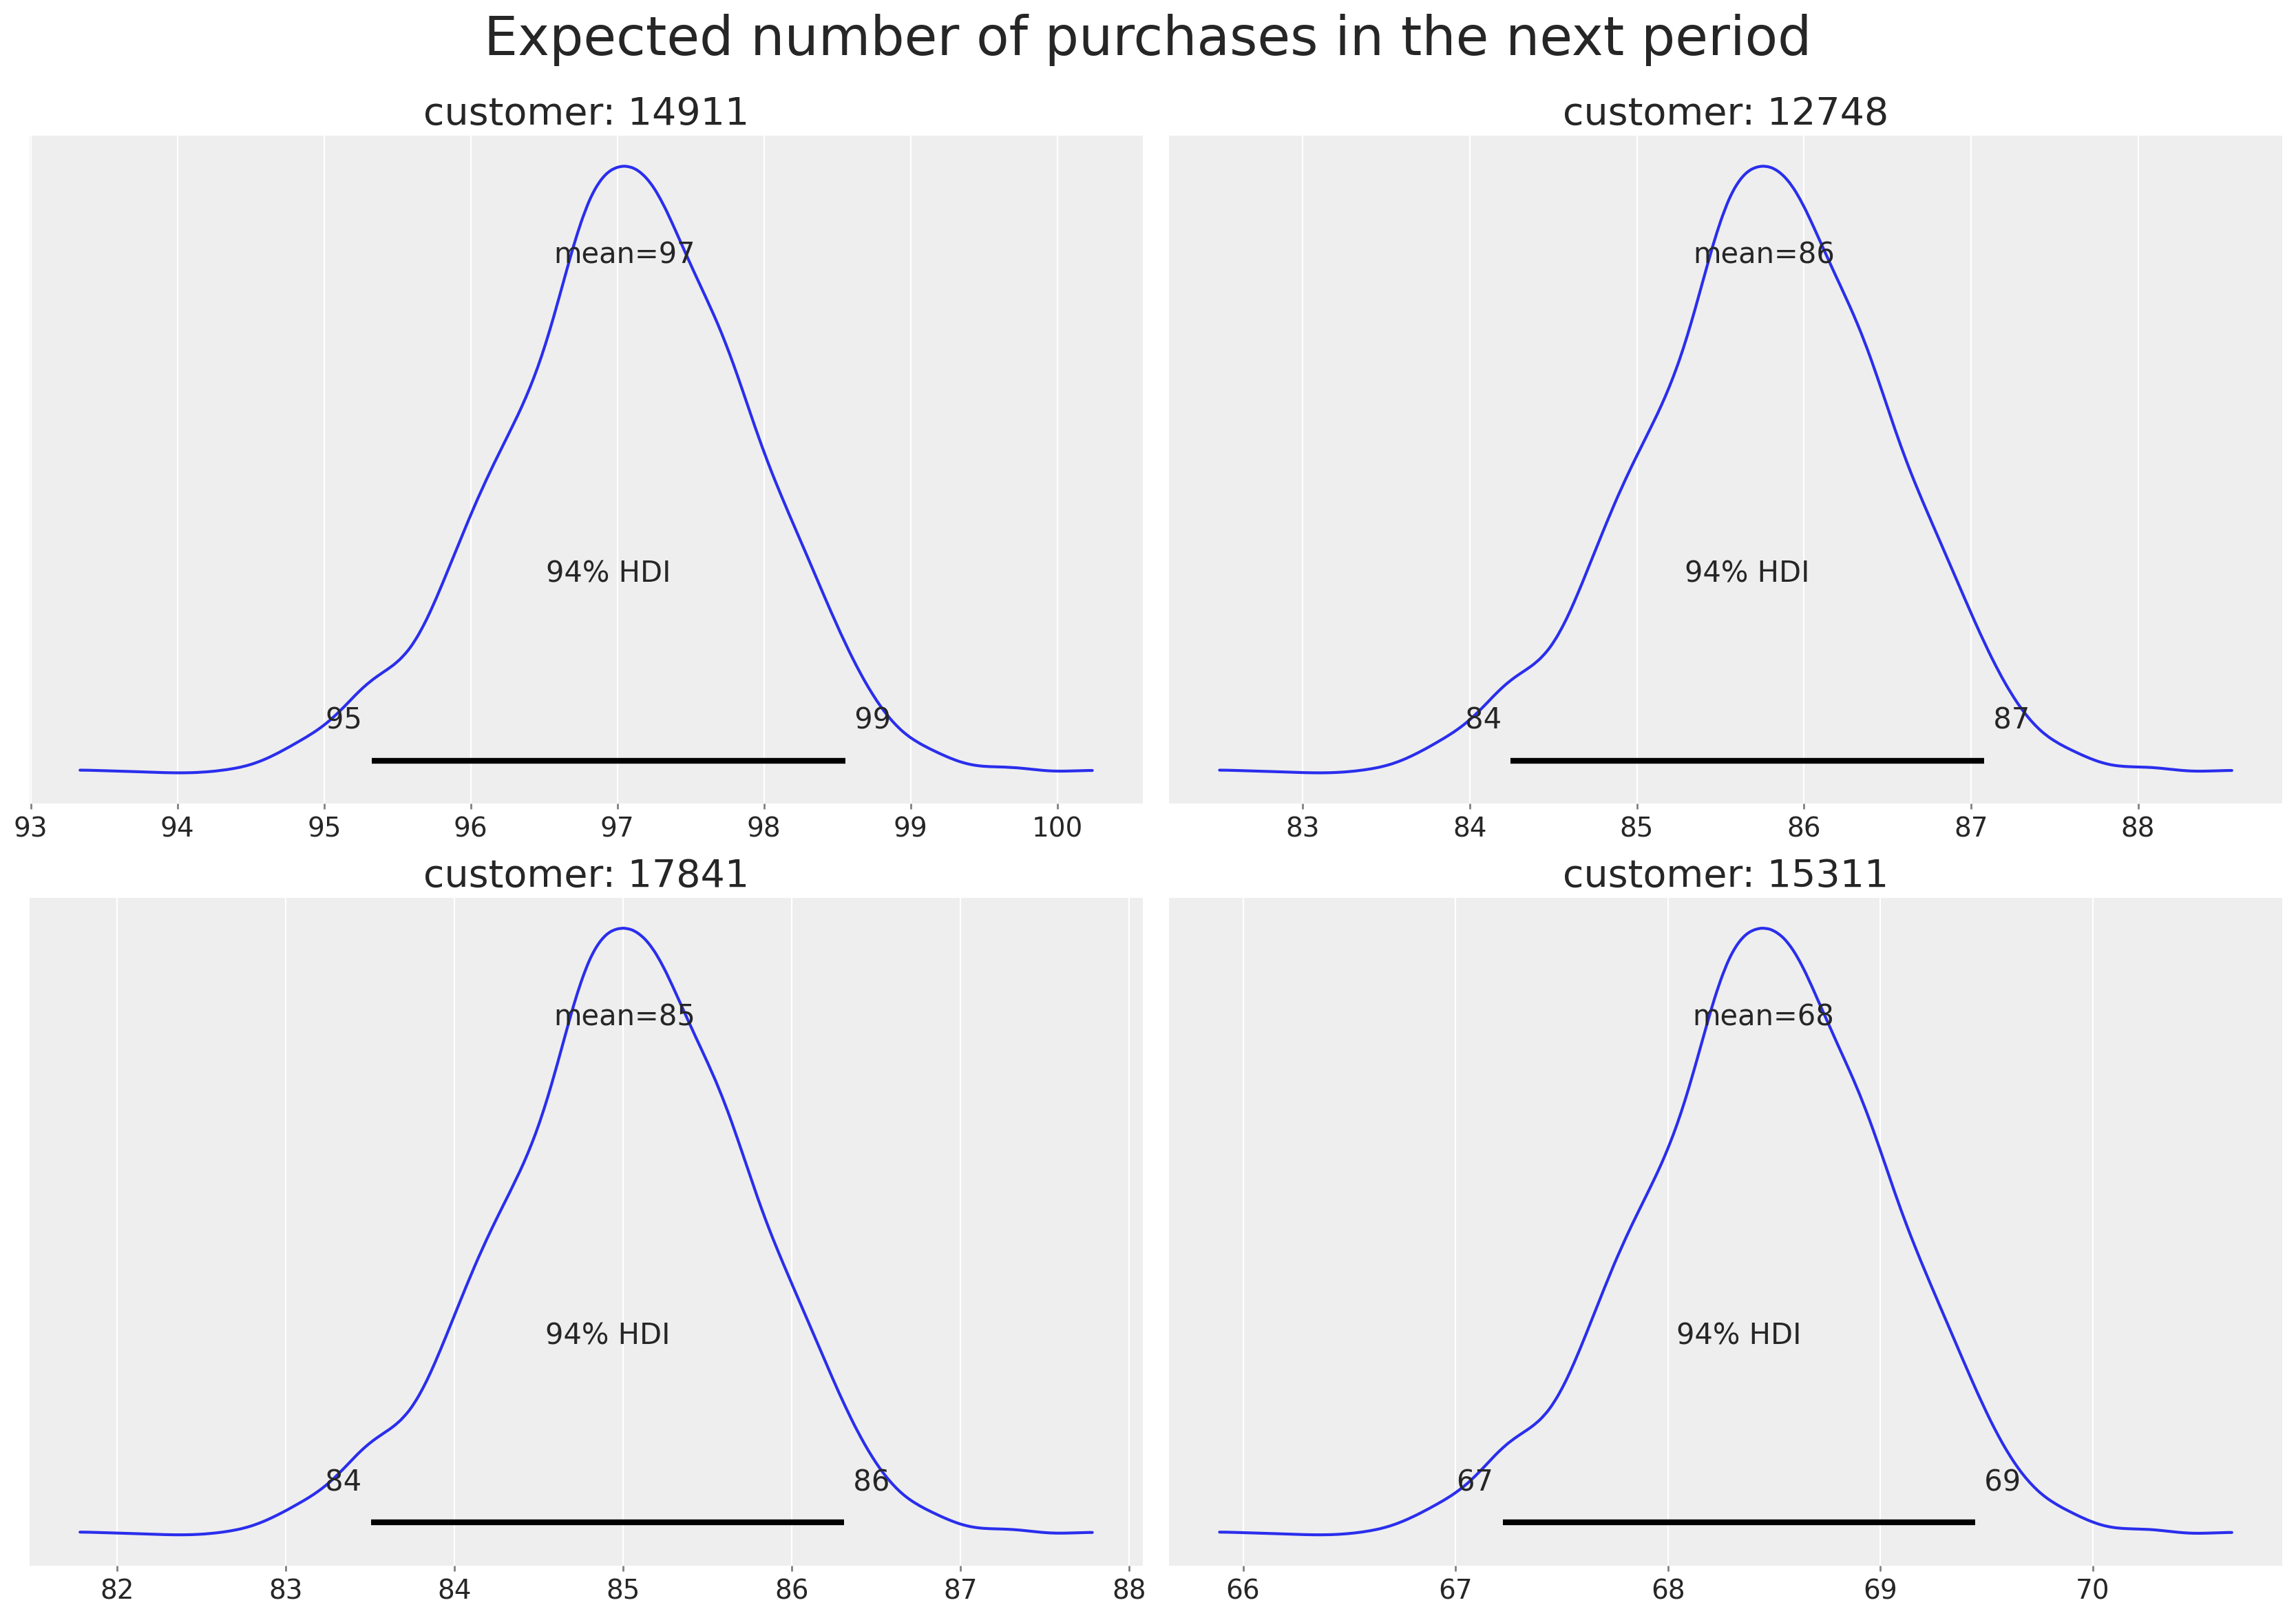

In [98]:
# Visulising the uncertainty in our predictions for the number of purchases
# This illustrates the range of likely outcomes, highlighting the probablistic nature of our predictions

ids = sdata.sort_values(by="expected_purchases", ascending=False).head(4)['customer_id'].tolist()
ax = az.plot_posterior(num_purchases.sel(customer_id=ids), grid=(2, 2));
for axi, id in zip(ax.ravel(), ids):
  axi.set_title(f"customer: {id}", size=20)
plt.suptitle("Expected number of purchases in the next period", fontsize=28, y=1.05);

In [99]:
# Estimating the purchaseing behaviour of a new brand new customer
# This pred is useful for understanding what purchasing behavior might be expected from prospective customers

az.plot_posterior(
    bgm.expected_purchases_new_customer(t=365)
);
plt.title("Expected purchases of a new customer in the first 365 periods");

/usr/local/lib/python3.11/dist-packages/arviz/plots/plot_utils.py:270: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (2778) in plot_posterior, generating only 40 plots
  warnings.warn(


In [100]:
# Selecting a specific customer to visualise their transaction history and model their future transaction probability

customer_id_viz = '14911'
customer_viz = data_summary_rfm.loc[customer_id_viz]
customer_viz  # Displaying the selected customer's historical summary.

customer_id           14911
frequency             127.0
recency               372.0
T                     373.0
monetary_value    953.53189
Name: 14911, dtype: object

In [101]:
# Constructing a hypothetical future transaction histroy for the selected customer over a ser period (30 units of time)

data_range = 30
customer_viz_history = pd.DataFrame(dict(
    ID=np.full(data_range, customer_id_viz, dtype="int"),
    frequency=np.full(data_range, customer_viz["frequency"], dtype="int"),
    recency=np.full(data_range, customer_viz["recency"]),
    T=(np.arange(-1, data_range-1) + customer_viz["T"]).astype("int"),

))
customer_viz_history # Viewing the constructed future transaction history.

ID  frequency  recency    T
0   14911        127    372.0  372
1   14911        127    372.0  373
2   14911        127    372.0  374
3   14911        127    372.0  375
4   14911        127    372.0  376
5   14911        127    372.0  377
6   14911        127    372.0  378
7   14911        127    372.0  379
8   14911        127    372.0  380
9   14911        127    372.0  381
10  14911        127    372.0  382
11  14911        127    372.0  383
12  14911        127    372.0  384
13  14911        127    372.0  385
14  14911        127    372.0  386
15  14911        127    372.0  387
16  14911        127    372.0  388
17  14911        127    372.0  389
18  14911        127    372.0  390
19  14911        127    372.0  391
20  14911        127    372.0  392
21  14911        127    372.0  393
22  14911        127    372.0  394
23  14911        127    372.0  395
24  14911        127    372.0  396
25  14911        127    372.0  397
26  14911        127    372.0  398
27  14911        127    372.0  399
28  14911        127    372.0  400
29  14911        127    372.0  401

In [110]:
# Calculating the probability of this customer being active (alive) using the BG/NBD model
# This predicts the likelihood f the customer returning for future purchases based on their transaction history

p_alive = bgm.expected_probability_alive(
    customer_id=customer_viz_history["ID"],
    frequency=customer_viz_history["frequency"],
    recency=customer_viz_history["recency"],
    T=customer_viz_history["T"],
)

TypeError: BetaGeoModel.expected_probability_alive() got an unexpected keyword argument 'customer_id'

In [109]:
# Visualizing the customer's probability of remaining active over the forecasted period.
# The shaded area represents the confidence interval, providing a range where the actual probability is likely to fall.

az.plot_hdi(customer_viz_history["T"], p_alive, color="C0")
plt.plot(customer_viz_history["T"], p_alive.mean(("draw", "chain")), marker="o")
plt.axvline(customer_viz_history["recency"].iloc[0], c="black", ls="--", label="Purchase")

plt.title(f"Probability Customer {customer_id_viz} will purchase again")
plt.xlabel("T")
plt.ylabel("p")
plt.legend();

TypeError: Dimension mismatch for x: (30,) and hdi: (2778, 2). Check the dimensions of y andhdi_kwargs to make sure they are compatible